In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# check if GPU working 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# switch off cudnn 
torch.backends.cudnn.enabled = False

print(device)


cuda


In [25]:

class EFR_CNN(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, input_size, hidden_size, num_layers, mlp_hidden_size, output_size):
        super(EFR_CNN, self).__init__()
        """
        ERC-CNN Module combining CNN, BiLSTM, and MLP
        Input shape: (batch_size, in_channels, width, length)
        Output shape: (batch_size, seq_length, output_size)
        """
        # CNN layers
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=(1, 1))
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=(1, 1))

        # BiLSTM layer
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)

        # MLP layers
        self.fc1 = nn.Linear(hidden_size * 2, mlp_hidden_size)
        self.fc2 = nn.Linear(mlp_hidden_size, output_size)

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = self.conv2(x)

        # BiLSTM
        x = x.squeeze(1)  # Remove the singleton dimension
        x, _ = self.bilstm(x)

        # MLP
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Define parameters
batch_size = 1
speakers = 10  # max_speakers
num_utterances = 24  # dialogue_length
embedding_size = 768

cnn_mid_channels = 3
cnn_out_channels = 1

hidden_lstm = 64
layers_lstm = 1

inputs_mlp = hidden_lstm * 2
hidden_mlp = 64
output_mlp = number_of_emotions = 2


# Create individual components
# Initialize the ERC_CNN class
model = EFR_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp)

input_tensor = torch.randn(batch_size, speakers, num_utterances, embedding_size)


# Forward pass through the model
output = model(input_tensor)  # Add batch dimension

print("Final Output shape:", output.shape)

Final Output shape: torch.Size([1, 24, 7])


In [26]:

class MyDataset(Dataset):
    def __init__(self, json_path = 'train_file.json'):
        self.embedding_model = SentenceTransformer('all-mpnet-base-v2')
        self.train_data = pd.read_json(json_path)

    def generate_cnn_embeddings(self, row):
        speakers = row['speakers']

        embeddings_list = self.embedding_model.encode(row['utterances'])

        speaker_index = {}
        index = 0
        for speaker in speakers:
            if speaker not in speaker_index:
                speaker_index[speaker] = index
                index += 1

        S = len(speaker_index)
        N = len(speakers)
        embeddings_tensor = np.zeros((max(10 , S), N, 768))
        for i, (speaker, embedding) in enumerate(zip(speakers, embeddings_list)):
            idx = speaker_index[speaker]
            embeddings_tensor[idx, i, :] = embedding
        return embeddings_tensor

    def gen_trigger_matrix(self, row):
        triggers = row['triggers']
        trigger_matrix = np.zeros((len(triggers), 2))
        for idx, trigger in enumerate(triggers):
            if trigger is None:
                trigger = 0
            trigger_matrix[idx][int(trigger)] = 1
        return trigger_matrix


    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        X = self.generate_cnn_embeddings(self.train_data.iloc[idx])
        Y = self.gen_trigger_matrix(self.train_data.iloc[idx])
        # print(X.shape, Y.shape)
        return X, Y

In [27]:
# Define parameters
batch_size = 1
speakers = 10  # max_speakers
num_utterances = 24  # dialogue_length
embedding_size = 768

cnn_mid_channels = 3
cnn_out_channels = 1

hidden_lstm = 64
layers_lstm = 1

inputs_mlp = hidden_lstm * 2
hidden_mlp = 64
output_mlp = number_of_triggers = 2


# Initialize the ERC_CNN class
model = EFR_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp)

# input_tensor = torch.randn(batch_size, speakers, num_utterances, embedding_size)

In [28]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [29]:
folder_path = "/content/drive/MyDrive/IIITD/Courses/nlp/Assignment 4/"
folder_path = ""

path_train_file = "train_file.json"
path_val_file = "val_file.json"

dataset = MyDataset(path_train_file)
val_dataset = MyDataset(path_val_file)

criterion = nn.CrossEntropyLoss().to(DEVICE)

model = EFR_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)



In [ ]:
model.train()

from tqdm import tqdm
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in tqdm(enumerate(dataloader)):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs.float())

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Print statistics
        running_loss += loss.item() * inputs.size(0)

        # tqdm.write(f"Training in Progress: {i+1}/{6000}")

    # Print average loss for the epoch
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    running_loss = 0.0
    for i, (inputs, labels) in tqdm(enumerate(val_data_loader)):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs.float())

        # Compute the loss
        loss = criterion(outputs, labels)

        # Print statistics
        running_loss += loss.item() * inputs.size(0)

        # tqdm.write(f"Training in Progress: {i+1}/{6000}")

    # Print average loss for the epoch
    epoch_loss = running_loss / len(val_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

In [ ]:
# save the model
torch.save(model.state_dict(), folder_path + "EFR_CNN.pth")
print("Model saved successfully")

Model saved successfully


In [58]:
# load the model first , name of model is : 'EFR_CNN.pth'

# print the prediction for the first element of the validation set

# loading the model from 'EFR_CNN.pth' file

model.load_state_dict(torch.load(folder_path + 'EFR_CNN.pth'))
model.eval()

for i, (inputs, labels) in tqdm(enumerate(val_data_loader)):
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    output = model(inputs.float())
    print(output)
    print(labels)
    break 

0it [00:00, ?it/s]

0it [00:00, ?it/s]

tensor([[[  6.6777, -10.0692],
         [  6.6459,  -6.5229],
         [  6.6356,  -7.7604],
         [  6.6738,  -6.8151],
         [  6.6337,  -7.3458],
         [  6.6066,  -7.6106],
         [  6.6294,  -7.1019],
         [  6.6259,  -8.8559],
         [  6.6328,  -7.8672],
         [  6.6069,  -8.8341],
         [  6.6320,  -5.7440],
         [  6.6617,  -7.3721],
         [  6.6190,  -6.1586],
         [  6.6048,  -8.1232],
         [  6.5109,  -0.0294],
         [  2.7239,   3.6574],
         [  6.5724,   0.4748]]], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([[[1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [1., 0.]]], device='cuda:0', dtype=torch.float64)


In [59]:
from sklearn.metrics import f1_score, confusion_matrix

model.load_state_dict(torch.load('EFR_CNN.pth'))
model.to(DEVICE)
model.eval()

predictions = []
true_labels = []

for inputs, labels in tqdm(val_data_loader):
    inputs = inputs.to(DEVICE)
    labels = labels[:, :, 1].type(torch.LongTensor).to(DEVICE)
    outputs = model(inputs.float())
    pred = outputs.argmax(dim=-1)
    #print("PREDICTION:" , pred)
    #print("LABELS    :", labels)
    predictions.extend(pred.cpu().numpy().flatten())
    true_labels.extend(labels.cpu().numpy().flatten())

100%|██████████| 843/843 [00:12<00:00, 66.12it/s]


Confusion Matrix:
 [[6173   13]
 [ 920  187]]
F1 Score: 0.6079450885541443


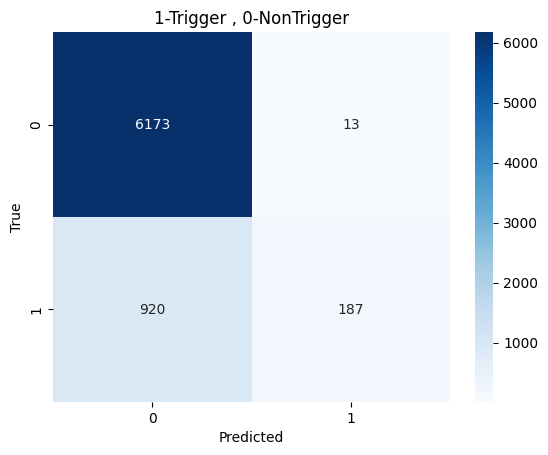

In [60]:
f1 = f1_score(true_labels, predictions, average='macro')
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:\n", cm)
print("F1 Score:", f1)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("1-Trigger , 0-NonTrigger" )
plt.show()
